## Exporting a SSD model to TensorFlow
You can use the Fireball's [exportToTf](https://interdigitalinc.github.io/Fireball/html/source/model.html#fireball.model.Model.exportToTf) function to export a model to TensorFlow code. This function creates a
python file that implements the model using TensorFlow APIs. It also creates a numpy file (npz) that contains the parameters of the network. This notebook shows how to use this function to export a Fireball model to TensorFlow. It is assumed that a trained SSD model already exists in the ```Models``` directory. Please refer to the notebook [Object Detection with SSD](SSD.ipynb) for more info about using a pretrained SSD model.

Fireball can also export models with reduced number of parameters, pruned models, and quatized models. Please refer to the following notebooks for more information:

- [Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)
- [Pruning SSD Model](SSD-Prune.ipynb)
- [Quantizing SSD Model](SSD-Quantize.ipynb)

## Load a pretrained model

In [1]:
from fireball import Model

orgFileName = "Models/SSD512RRPRQR.fbm"  # Reduced - Retrained - Pruned - Retrained - Quantized - Retrained

model = Model.makeFromFile(orgFileName, gpus='0')
model.printLayersInfo()
model.initSession()


Reading from "Models/SSD512RRPRQR.fbm" ... Done.
Creating the fireball model "SSD512" ... Done.

Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_IMG                         Image Size: 512x512x3    512 512 3     None                      0          
S1_L1_CONV       512 512 3     KSP: 3 1 s               512 512 64    ReLU                      1,680      
S1_L2_CONV       512 512 64    KSP: 3 1 s               256 256 64    ReLU     MP(KSP):2 2 s    28,321     
S2_L1_CONV       256 256 64    KSP: 3 1 s               256 256 128   ReLU                      52,797     
S2_L2_CONV       256 256 128   KSP: 3 1 s               128 128 128   ReLU     MP(KSP):2 2 s    100,940    
S3_L1_CONV       128 128 128   KSP: 3 1 s, LR136        128 128 256   ReLU                      146,005    
S3_L2_CONV       128 128 256   KSP: 3 

## Export the model
Fireball creates a folder and puts 2 files in the folder. Here we call the [exportToTf](https://interdigitalinc.github.io/Fireball/html/source/model.html#fireball.model.Model.exportToTf) funtion to export the model.

In [2]:
from fireball.datasets.coco import CocoDSet

# We don't need any datasets here. We are just doing this to initialize the CocoDSet
# so that we can get classNames which is needed for the "exportToCoreMl" function below.
CocoDSet.makeDatasets('Test', batchSize=128, resolution=512, keepAr=False, numWorkers=4)

model.exportToTf("Models/SSD512_TF", runQuantized=True, classNames=CocoDSet.classNames)



Exporting to TensorFlow model "Models/SSD512_TF" ... 
    Processed all 28 layers.                                     
    Creating parameters file "Params.npz" ... Done.
Done.


## Running inference on the exported model
To verify the exported model, we can now run inference on it. Here we load an image and do the required pre-processing before passing it to the exported model as input. We then print the information about the detected objects and display them on the original image using the ```matplotlib``` library.

**NOTE**: Please reset the kernel before running the next cell.

Number of detected objects: 17
    0: orange (99%) at [0.7682233 0.6980905 0.9858184 0.9706096]
    1: orange (98%) at [0.74302995 0.25701252 0.93946016 0.46199527]
    2: banana (98%) at [0.49387866 0.3978268  0.7835615  1.        ]
    3: orange (97%) at [0.23686531 0.10570087 0.41677406 0.30925775]
    4: apple (97%) at [0.35919803 0.22409883 0.56003284 0.4692621 ]
    5: orange (97%) at [0.7918138 0.4534297 0.9949327 0.7110237]
    6: apple (92%) at [0.06303797 0.2125421  0.27607888 0.45119345]
    7: orange (91%) at [0.643775   0.02501971 0.8043822  0.2519812 ]
    8: orange (85%) at [0.4760102  0.05711503 0.645658   0.27541947]
    9: apple (81%) at [0.15777412 0.6204735  0.34809396 0.9039211 ]
    10: orange (81%) at [0.5574888  0.20939572 0.7555777  0.41750985]
    11: apple (77%) at [0.33324552 0.6728093  0.5249707  0.97834426]
    12: apple (72%) at [0.0480024  0.46489197 0.23322132 0.7357791 ]
    13: apple (67%) at [0.         0.30828553 0.68732464 0.9395638 ]
    14: apple

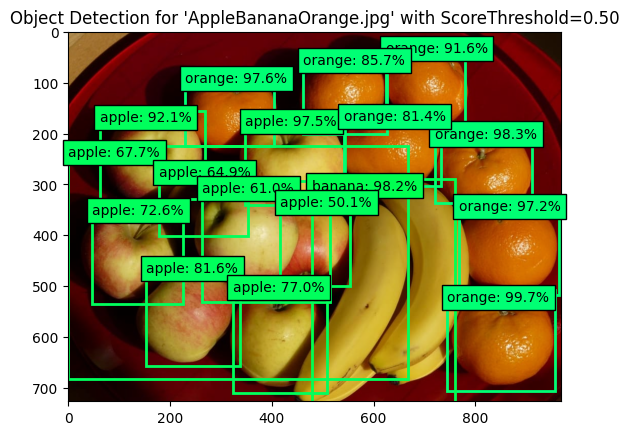

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# First load and pre-process the image:
imgFileName = "AppleBananaOrange.jpg"
img = np.float32(cv2.imread(imgFileName)) # BGR format

# Scale the image to 512x512:
res = 512
imgH,imgW,_ = img.shape
imgSize = (imgW, imgH)
scaleX = np.float32(res) / imgW
scaleY = np.float32(res) / imgH
scaledImg = cv2.resize(img, (res, res),
                       interpolation = (cv2.INTER_AREA if scaleX<1.0 else cv2.INTER_CUBIC))
            
# Normalize the image using the mean values for blue, green, and red
netInput = np.float32(scaledImg-[103.939, 116.779, 123.68])

from Models.SSD512_TF.TfModel import Network
net=Network(maxDetectionsPerImage=20, maxDetectionPerClass=20, scoreThreshold=.5)
classNames = net.getClassNames()

# Run inference:
dtClasses, dtBoxes, dtScores, dtNum = net.infer([netInput])

# Convert image to RGB to show it in matplotlib
img = (img/256)[..., ::-1]    
currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, 121)).tolist()

print("Number of detected objects: %d"%(dtNum))
for i in range(int(dtNum)):
    label, box, score = int(dtClasses[0][i]), dtBoxes[0][i], dtScores[0][i]
    print("    %d: %s (%d%%) at %s"%(i, classNames[label],int(score*100),str(box)))

    caption = "%s: %2.1f%%"%(classNames[ label ], score*100)
    box *= [imgW,imgH,imgW,imgH]
    x,y, w,h = np.int32( np.rint(box) )
    w-=x
    h-=y
    
    currentAxis.add_patch(plt.Rectangle((x,y), w,h, fill=False, edgecolor=colors[ label ], linewidth=2))
    currentAxis.text(x,y, caption, bbox={'facecolor':colors[ label ]}, verticalalignment='top')

imgplot = plt.imshow(img)
plt.title("Object Detection for '%s' with ScoreThreshold=%.2f"%(imgFileName, net.scoreThreshold))
plt.show()

## Also look at

[Exporting SSD Model to CoreML](SSD-CoreML.ipynb)

[Exporting SSD Model to ONNX](SSD-ONNX.ipynb)

---

[Fireball Playgrounds](../Contents.ipynb)

[Object Detection with SSD](SSD.ipynb)

[Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)

[Pruning the SSD Model](SSD-Prune.ipynb)

[Quantizing SSD Model](SSD-Quantize.ipynb)
